# Neural network
Because none of us have implemented a neural network before, our first goal is to create a simple network that is somewhat capable of recognizing the images. We will be using [this blog post \[1\]](https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627) as a reference for our model and the choice of hyper parameters.

## Initializing and loading the data set

First, we import all the libraries which we will be using for the project.

In [3]:
import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from IPython.display import HTML, Image, display
from time import time

In [40]:
# Use a constant seed for randomness so that reruns becomes predictable
random_seed = 1
torch.manual_seed(random_seed)

torch.backends.cudnn.enabled = False

Pytorch already have a predefined function for loading the MNIST dataset which we will be using. In addition to that the following code converts the images to Pytorch tensors and normalizes the pixels to values in the range \[0, 1\]. The batch sizes where taken from [1]TODO.

In [5]:
batch_size_train = 64
batch_size_test = 1000

training_set = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                             torchvision.transforms.Normalize((0.5,), (0.5,))])),batch_size=batch_size_train, shuffle=True)

test_set = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.5,), (0.5,))])),batch_size=batch_size_test, shuffle=True)

Inspecting the first tensor from the training set, we can see that it has the dimensionality of 64 x 1 x 28 x 28, where 64 is the number of images in that batch and the 28x28 is the width and height of the images in pixels.

In [6]:
examples = enumerate(training_set)
_, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([64, 1, 28, 28])

To see what we are actually working with, we have this function that displays the images in grayscale along with their labels.

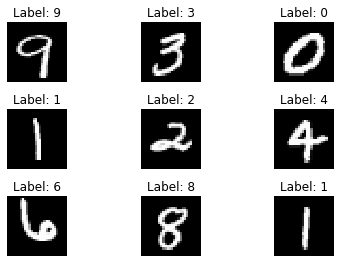

In [7]:
def plot_grayscale_images(m, n, images, labels):
    fig = plt.figure()
    for i in range(m * n):
        plt.subplot(m, n, i + 1)
        plt.tight_layout()
        plt.imshow(images[i][0], cmap='gray', interpolation='none')
        plt.title("Label: {}".format(labels[i]))
        plt.axis('off')
        
plot_grayscale_images(3, 3, example_data, example_targets)

Now that we know that the data loaders work correctly, we can go on to implementing the model.

## Creating a basic model

In [8]:
class BasicModel(nn.Module):
    def __init__(self):
        super(BasicModel, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(28 * 28, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            nn.LogSoftmax(1)
        )
        
        self.criterion = nn.NLLLoss()
        self.optimizer = optim.SGD(self.parameters(), lr=0.01, momentum=0.5)
    
    
    def forward(self, tensor):
        tensor = tensor.reshape(tensor.size(0), -1)
        return self.net(tensor)
    
    
    def fit(self, tensor, labels):
        result = self(tensor)
        
        self.optimizer.zero_grad()
        loss = self.criterion(result, labels)
        loss.backward()
        self.optimizer.step()
        
        _, predictions = torch.max(result, 1)
        total = tensor.size(0)
        nr_correct = torch.sum(predictions == labels).item()
        
        return (nr_correct / total, loss.item())

The structure of our basic model is a 784 node input layer (the size of an image when converted to a vector) connected to a 50 node hidden layer with the ReLU activation function and a 10 node output layer. For the hidden layer we tried various ranges between the input and output layer sizes but we realized that searching for hyper parameters manually is kinda inpractical and settled for 50 nodes which gave decent accuracy. 

The output layer is normalized with LogSoftmax. Softmax is a function which normalizes a vector to values in the range \[0, 1\], where all the components of the output vector add up to 1. The reason for using Softmax is because we want our output from the network to be a probability vector of each of the labels. LogSoftmax is taking the Log of Softmax which have the result of punishing incorrect values more which is good for classification problems TODO REFERENCE THIS.

TODO CRITERION, OPTIMIZER, LEARNING RATE, MOMENTUM

_forward:_ Since we are extending _nn.Module_ this function gets called when we are running the network. We convert each image to a vector and then feeds them through the network. 

_fit:_ Runs the network and backpropagate using the criterion and optimizer. Returns the accuracy and loss of the input tensor.

In [9]:
def train_model(epochs, model, data_set):
    accuracy = []
    for n in range(epochs):
        for (images, labels) in data_set:
            (batch_accuracy, batch_loss) = model.fit(images, labels)
            accuracy.append(batch_accuracy)
    return accuracy


def test_model(model, data_set):
    total = 0
    nr_correct = 0
    
    for images, labels in data_set:
        result = model(images)
        
        _, predictions = torch.max(result, 1)
        total += images.size(0)
        nr_correct += torch.sum(predictions == labels).item()
                
    return nr_correct / total

The *train_model* function iterates through all the batches of the data set for *epochs* number of times and aggregates the accuracy and loss for each batch.
*test_model* does the same as *train_model* except it does no backpropagation.

In order to see how the accuracy of our network changes during the training we have created following function which takes a list of batch accuracies and plots them.

In [10]:
def plot_learning_rate(batch_accuracies):
    fig, ax = plt.subplots()
    ax.plot(
        range(0, len(batch_accuracies)), 
        batch_accuracies
    )

    ax.set_ylim((0, 1))
    ax.set(
        xlabel='training batch', 
        ylabel='accuracy',
        title='Model accuracy during training'
    )

    plt.show()

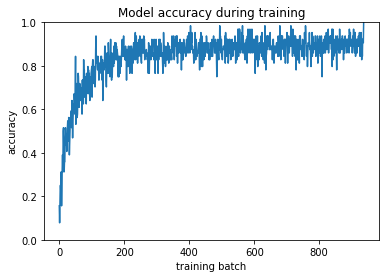

Model has an accuracy of 90.10%


In [13]:
model = BasicModel()
accuracy = train_model(1, model, training_set)
plot_learning_rate(accuracy)
accuracy = test_model(model, test_set)
print('Model has an accuracy of {:0.2f}%'.format(accuracy * 100))

Now putting it all together, we can that the network quickly increases to 80% accuracy and then slowly increases to around 90%. Not that great accuracy but at least the network learnings something from the data set. Control checking it to the test set we can see that the learning generalizes.

By plotting images next to their prediction vector, we can get a sense of which digit that perform badly. Most of the times the network gets confused the digit is porly written although a human can see what it is.

In [45]:
def plot_grayscale_image_with_classification(img, ps):
    ps = ps.cpu().data.numpy().squeeze()
    
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze(), cmap='gray', interpolation='none')
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Prediction')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit:  3
Original Label:  3


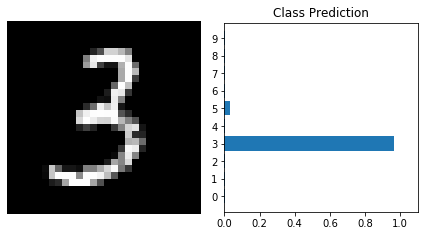

In [47]:
images, labels = next(iter(test_set))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit: ", probab.index(max(probab)))
print("Original Label: ", labels[0].item())
plot_grayscale_image_with_classification(img.view(1, 28, 28), ps)

# Creating the CNN and searching for hyper params

As mentioned earlier we realized that searching for hyper parameters manually is inefficent and we decided that we would do a search to find a good set instead. Deciding between doing a random search and a grid search, we finally settled for grid search even though it would require us go through alot of combinations. In order to reduce the number of combinations we had to limit us to very few values of each parameter. Because it still would become alot of combinations we decided to only do one epoch for each model and then selecting the best performing ones to test further with more epochs. The disadvantage of this approach is that me might have missed out on models which performed poorly for the first epoch but that might have performed much better when training them longer.

## CNN Model

In [ ]:
class Model(nn.Module):
    def __init__(self, hyper_params):
        super(Model, self).__init__()
        self.hyper_params = hyper_params
        
        layers = []
        for n in self.hyper_params['conv_layers']:
            conv_layer = nn.Conv2d(
                n['in_channels'], 
                n['out_channels'], 
                n['kernel_size']
            )
            layers.append(conv_layer)
            layers.append(self.get_activation_function())
            layers.append(nn.MaxPool2d(2))
        self.conv = nn.Sequential(*layers)
        
        layers = []
        for i in range(len(self.hyper_params['regular_layers']) - 1):
            nr_in = self.hyper_params['regular_layers'][i];
            nr_out = self.hyper_params['regular_layers'][i + 1];
            layers.append(nn.Linear(nr_in, nr_out))
            layers.append(self.get_activation_function())
        
        # The output layer should not have an activation function
        layers.pop()
        
        self.net = nn.Sequential(*layers)
          
        learning_rate = self.hyper_params['learning_rate']
        momentum = self.hyper_params['momentum']
        optimizer = self.hyper_params['optimizer']
        if optimizer == 'SGD':
            self.optimizer = optim.SGD(self.parameters(), lr=learning_rate, momentum=momentum)
        elif optimizer == 'Adam':
            self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        else:
            raise Exception('Invalid optimizer')
            
        criterion = self.hyper_params['criterion']
        if criterion == 'CrossEntropy':
            self.criterion = nn.CrossEntropyLoss()
        else:
            raise Exception('Invalid criterion')
            
        if run_on_gpu:
            self.to(device)
        
        
    def get_activation_function(self):
        fun = self.hyper_params['activation_function']
        if fun == 'ReLU':
            return nn.ReLU()
        if fun == 'Sigmoid':
            return torch.nn.Sigmoid()
        if fun == 'Swish':
            return Swish()
        
        
    def forward(self, tensor):
        tensor = self.conv(tensor)
        tensor = tensor.reshape(tensor.size(0), -1)
        return self.net(tensor)
    
    
    def fit(self, tensor, labels):
        if run_on_gpu:
            tensor = tensor.to(device)
            labels = labels.to(device)
        result = self(tensor)
        
        self.optimizer.zero_grad()
        loss = self.criterion(result, labels)
        loss.backward()
        self.optimizer.step()
        
        _, predictions = torch.max(result, 1)
        total = tensor.size(0)
        nr_correct = torch.sum(predictions == labels).item()
        
        return (nr_correct / total, loss.item())

Instead of a hard coded network like our previous model, this model takes in a dictionary of hyper parameters and then constructs the layers from it. This allows us to have a variable amount of layers and different activation functions etc. We have also added support for convolutional layers. For each convolutional layer we have one activation function and then a pooling layer, which we based on TODO REFERENCE. The reason that we have chosen to have a dictionary instead of multiple parameters to the constructor is that we wanted an easy way to save, load and print the models parameters.

*forward* works that same as the previous model except that it runs the convolutional layers before convertering the tensor to a vector.

*fit* is exactly the same as the previous model

## Hyper Parameter Tuning with Grid Search

In [ ]:
def hyper_parameter_permutations():
    layer_sizes = [32, 64, 128]
    hidden_layers = [list(n) for n in itertools.permutations(layer_sizes, 1)]\
                  + [[a, b] for (a, b) in itertools.permutations(layer_sizes, 2) if a >= b]
    
    channel_sizes = [4, 8, 16]
    conv_layers = [list(n) for n in itertools.permutations(channel_sizes, 1)]\
                + [[a, b] for (a, b) in itertools.permutations(channel_sizes, 2) if a <= b]
    
    kernel_sizes = [5]
    activation_functions = ['ReLU', 'Sigmoid', 'Swish']
    criterions = ['CrossEntropy']
    
    #Adding momentum directly to the optimizer since it's only used for SGD
    optimizers = [('SGD', 0.1), ('SGD', 0.5), ('SGD', 1.0), 'Adam']
    learning_rates = [0.1, 0.01, 0.001]

    return itertools.product(
        hidden_layers,
        conv_layers,
        kernel_sizes,
        activation_functions,
        criterions,
        optimizers,
        learning_rates
    )

In [ ]:
class Swish(nn.Module):
    def forward(self, input_tensor):
        return input_tensor * torch.sigmoid(input_tensor)

TODO

In [ ]:
def permutation_to_dictionary(hidden_layers, channel_sizes, kernel_size, act_fun, criterion, optimizer, learning_rate):
    conv_layers = []
    in_channels = 1
    side_length = 28
    for channel_size in channel_sizes:
        out_channels = channel_size
        conv_layers.append(
            {
                'in_channels': in_channels,
                'out_channels': out_channels,
                'kernel_size': kernel_size
            }
        )
        in_channels = out_channels
    
        side_length -= kernel_size - 1
        side_length //= 2
        
    if type(optimizer) is tuple:
        momentum = optimizer[1]
        optimizer = optimizer[0]
    else:
        momentum = 0
    
    regular_layers = [side_length * side_length * out_channels] + hidden_layers + [10]
    return {
        'conv_layers': conv_layers,
        'regular_layers': regular_layers,
        'activation_function': act_fun,
        'optimizer': optimizer,
        'criterion': criterion,
        'learning_rate': learning_rate,
        'momentum': momentum
    }

TODO

In [ ]:
def grid_search():
    gc.collect()
    before = time.time()

    models = []
    
    permutations = list(hyper_parameter_permutations())
    
    print("Searching through {} permutations".format(len(permutations)))

    i = 0
    for n in permutations:
        grid_search_helper(n, models)
        break
        i += 1
        
        if i % 100 == 0:
            print("{} complete, time elapsed: {:.2f} minutes".format(i, (time.time() - before) / 60))
            
        if i % 500 == 0:
            gc.collect()

    models.sort(key=lambda n: n[0], reverse=True)

    after = time.time()
    print("Done, took {:.2f} minutes".format((after - before) / 60))
    
    return models

# Wrapper function that allows the garbage collector to run
def grid_search_helper(permutation, models):
    hyper_params = permutation_to_dictionary(*permutation)
    model = Model(hyper_params)
    train_model(model)
    accuracy = test_model(model, test_set)
    models.append((accuracy, model.hyper_params))


TODO

In [ ]:
def write_json(params, filename):
    params_json = json.dumps(params)
    f = open(filename, "w")
    f.write(params_json)
    f.close()
    
def read_json(filename):
    f = open(filename, "r")
    params = json.loads(f.read())
    f.close()
    return params

Because we don't want to perform our lengthy grid search multiple times, we have a simple read/write to a json file.

In [ ]:
epochs = 1
models = grid_search()
write_json(models, "one_epoch_models.json")

*BLOCK ABOUT RUNNING IT + DISPLAY GRAPH + DRAW CONCLUSION ABOUT HYPER PARAMS*